# Data Science Classification Project: Predict ODI Match Winner

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [3]:
train = pd.read_csv('E:/DataSetHackathon/Train_9.csv')
test  = pd.read_csv('E:/DataSetHackathon/Test_9.csv')

In [4]:
train.head()

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner
0,5,4,37,4,Home,Away,Second,First,Dec,4
1,1,14,84,7,Neutral,Neutral,First,Second,Sep,1
2,9,15,47,9,Home,Away,First,Second,Feb,9
3,7,2,102,6,Home,Away,First,Second,Aug,2
4,6,8,46,5,Home,Away,First,Second,Aug,6


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Team1          2508 non-null   int64 
 1   Team2          2508 non-null   int64 
 2   Stadium        2508 non-null   int64 
 3   HostCountry    2508 non-null   int64 
 4   Team1_Venue    2508 non-null   object
 5   Team2_Venue    2508 non-null   object
 6   Team1_Innings  2508 non-null   object
 7   Team2_Innings  2508 non-null   object
 8   MonthOfMatch   2508 non-null   object
 9   MatchWinner    2508 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 196.1+ KB


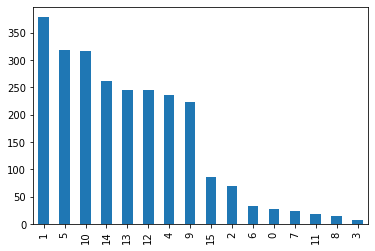

In [6]:
train.MatchWinner.value_counts().plot.bar()

# Feature Engineering

In [7]:
def team_dummy(df):
    dum=df[['Team1','Team2']]
    dum=dum.astype(str)
    dummy = dum.stack().str.get_dummies().sum(level=0)
    dummy = dummy.astype(int)
    df = pd.concat([df,dummy], axis=1)
    df.drop(['Team1','Team2'], axis=1, inplace=True)
    return df

In [8]:
train=team_dummy(train)
test=team_dummy(test)

In [9]:
total = pd.concat([train,test])
total.shape

(3583, 24)

In [10]:
total.head()

,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,0,1,...,14,15,2,3,4,5,6,7,8,9
0,37,4,Home,Away,Second,First,Dec,4.0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,84,7,Neutral,Neutral,First,Second,Sep,1.0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,47,9,Home,Away,First,Second,Feb,9.0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,102,6,Home,Away,First,Second,Aug,2.0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,46,5,Home,Away,First,Second,Aug,6.0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [11]:
dummy = pd.get_dummies(total['HostCountry'], prefix='HostCountry_')
total = pd.concat([total,dummy], axis=1)
total.drop('HostCountry',1,inplace=True)
total.head()

,Stadium,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,0,1,10,...,HostCountry__7,HostCountry__8,HostCountry__9,HostCountry__10,HostCountry__11,HostCountry__12,HostCountry__13,HostCountry__14,HostCountry__15,HostCountry__16
0,37,Home,Away,Second,First,Dec,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,84,Neutral,Neutral,First,Second,Sep,1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,47,Home,Away,First,Second,Feb,9.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,102,Home,Away,First,Second,Aug,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,46,Home,Away,First,Second,Aug,6.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cat=total.select_dtypes(object).columns.to_list()
cat

['Team1_Venue',
 'Team2_Venue',
 'Team1_Innings',
 'Team2_Innings',
 'MonthOfMatch']

In [13]:
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
for items in cat:
    total[items]=le.fit_transform(total[items])

In [14]:
total.head()

,Stadium,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner,0,1,10,...,HostCountry__7,HostCountry__8,HostCountry__9,HostCountry__10,HostCountry__11,HostCountry__12,HostCountry__13,HostCountry__14,HostCountry__15,HostCountry__16
0,37,1,0,1,0,2,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,84,2,2,0,1,11,1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,47,1,0,0,1,3,9.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,102,1,0,0,1,1,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,46,1,0,0,1,1,6.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
train_final=total[:train.shape[0]]
test_final=total[train.shape[0]:]

In [16]:
X=train_final.drop('MatchWinner',1)
y=train.MatchWinner
test_final=test_final.drop('MatchWinner',1)

In [17]:
x_train = X.values
y_train = y.values

## Hyperparameter tuning of XtremeGradientBoosting Classifier using Bayesian optimization

In [18]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, target):
    estimator = XGBClassifier(
            n_estimators=n_estimators,
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring='neg_log_loss', cv=5)
    
    return cval.mean()

In [19]:
def optimize_xgb(data, target):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            target=target,
        )
    optimizer = BayesianOptimization(
            f=xgb_crossval,
            pbounds={
                "n_estimators":(150,550),
                "max_depth": (1,20),
                "gamma":(0,10),
                "min_child_weight":(0,10),
                "subsample":(0.8,1.0)
                },
            random_state=1234,
            verbose=2
      )
    optimizer.maximize(n_iter=15 , init_points=10)
    
    
    print('Final Result:', optimizer.max)

In [20]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(x_train, y_train)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.6567   |  1.915    |  12.82    |  4.377    |  464.1    |  0.956    |
|  2        | -0.6837   |  2.726    |  6.253    |  8.019    |  533.3    |  0.9752   |
|  3        | -0.6785   |  3.578    |  10.52    |  6.835    |  435.1    |  0.8741   |
|  4        | -0.6822   |  5.612    |  10.56    |  0.1377   |  459.1    |  0.9765   |
|  5        | -0.6652   |  3.649    |  12.69    |  0.7538   |  297.5    |  0.9866   |
|  6        | -0.726    |  6.514    |  8.547    |  7.887    |  276.7    |  0.9136   |
|  7        | -0.757    |  8.691    |  9.287    |  8.021    |  207.5    |  0.9409   |
|  8        | -0.7491   |  7.046    |  5.157    |  9.249    |  326.9    |  0.9819   |
|  9        | -0.7974   |  0.5981   |  4.501    |  0.4736   |  420.0    |  0.9189   |
|  10       | -0.7005   |  

In [21]:
xgb = XGBClassifier(
        n_estimators=int(289.676679156488),
        max_depth = int(16.66163971577418),
        gamma = 3.1634650977473178,
        min_child_weight = 3.552460165210979,
        subsample = 0.8843846167683279,
        random_state = 42,
    )

## Hyperparameter tuning of ExtratreesClassifier using Bayesian optimization

In [22]:
def etc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = ExtraTreesClassifier(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=2,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring='neg_log_loss', cv=5)
    
    return cval.mean()

In [23]:
def optimize_etc(data, target):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
                n_estimators=int(n_estimators),
                min_samples_split=int(min_samples_split),
                max_features=max(min(max_features, 0.999), 1e-3),
                data=data,
                target=target,
                )
    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators":(100,450),
            "min_samples_split":(2,25),
            "max_features": (0.1,0.9)
        },
        random_state=42,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)
    
    print("Final result:", optimizer.max)

In [38]:
print(Colours.yellow("--- Optimizing Extra Trees ---"))
optimize_etc(x_train, y_train)

--- Optimizing Extra Trees ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.7024   |  0.3996   |  23.87    |  356.2    |
|  2        | -1.39     |  0.5789   |  5.588    |  154.6    |
|  3        | -0.7463   |  0.1465   |  21.92    |  310.4    |
|  4        | -4.884    |  0.6665   |  2.473    |  439.5    |
|  5        | -1.392    |  0.766    |  6.884    |  163.6    |
|  6        | -5.397    |  0.9      |  2.0      |  246.4    |
|  7        | -0.7012   |  0.4189   |  24.77    |  357.3    |
|  8        | -0.9339   |  0.9      |  25.0     |  100.0    |
|  9        | -5.626    |  0.9      |  2.0      |  100.0    |
|  10       | -4.879    |  0.6322   |  2.022    |  328.1    |
|  11       | -0.8346   |  0.1      |  25.0     |  292.9    |
|  12       | -0.7875   |  0.1      |  9.622    |  373.2    |
|  13       | -0.9016   |  0.9      |  25.0     |  390.2    |
|  14       | -0.835    |  0.1      |  

In [39]:
etc = ExtraTreesClassifier(n_estimators=int(357.2627108184671),
                         min_samples_split=int(24.76847660733257),
                         max_features=0.4188542761823595,
                         n_jobs = -1,
                         random_state = 42)

## Hyperparameter tuning of RandomForestClassifier using Bayesian optimization

In [40]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = RandomForestClassifier(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring='neg_log_loss', cv=5)
    
    return cval.mean()

In [41]:
def optimize_rfc(data, target):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.9), 1e-3),
            data=data,
            target=target,
            )
    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators":(100,550),
            "min_samples_split":(2,25),
            "max_features":(0.1,0.9),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)
    
    print("Final result:", optimizer.max)

In [42]:
print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(x_train, y_train)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.7135   |  0.2532   |  16.31    |  297.0    |
|  2        | -0.7638   |  0.7283   |  19.94    |  222.7    |
|  3        | -0.7003   |  0.3212   |  20.44    |  531.2    |
|  4        | -0.7989   |  0.8007   |  10.23    |  325.4    |
|  5        | -0.7389   |  0.6468   |  18.39    |  266.6    |
|  6        | -0.7053   |  0.301    |  20.48    |  530.0    |
|  7        | -0.7242   |  0.4337   |  16.37    |  543.2    |
|  8        | -0.8039   |  0.9      |  8.819    |  532.0    |
|  9        | -0.7307   |  0.771    |  24.98    |  536.2    |
|  10       | -0.7108   |  0.3245   |  19.03    |  289.8    |
|  11       | -0.7092   |  0.3408   |  10.84    |  290.3    |
|  12       | -0.7398   |  0.5178   |  13.77    |  281.8    |
|  13       | -0.8652   |  0.9      |  6.689    |  297.7    |
|  14       | -0.8804   |  0.1      |

In [43]:
rfc = RandomForestClassifier(n_estimators = int(529.7593232052407),
                           min_samples_split=int(22.61049017623624),
                           max_features = 0.3978290230141477,
                           n_jobs = -1, 
                           random_state = 42)

## Hyperparameter tuning of LightGradientBoostingClassifiier using Bayesian optimization

In [44]:
def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, target):
    estimator = LGBMClassifier(
        n_estimators=n_estimators,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring='neg_log_loss', cv=5)
    
    return cval.mean()

In [50]:
def optimize_lgb(data, target):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves= int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            target=target,
        )
    
    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators":(100,550),
            "num_leaves":(30,90),
            "min_child_samples":(5,30),
            "subsample":(0.6,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)
    
    print("Final result:", optimizer.max)

In [56]:
print(Colours.blue("--- Optimizing Light GBM ---"))
optimize_lgb(x_train, y_train)

--- Optimizing Light GBM ---
|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        | -2.158    |  9.788    |  379.9    |  56.26    |  0.9141   |
|  2        | -1.053    |  24.5     |  222.7    |  46.59    |  0.9207   |
|  3        | -1.819    |  28.95    |  494.2    |  51.47    |  0.8004   |
|  4        | -1.737    |  22.09    |  420.7    |  52.22    |  0.8245   |
|  5        | -0.7828   |  17.58    |  106.2    |  76.37    |  0.9531   |
|  6        | -0.7772   |  30.0     |  144.4    |  30.0     |  0.6      |
|  7        | -0.8119   |  15.31    |  106.7    |  77.52    |  0.9151   |
|  8        | -0.8396   |  30.0     |  166.9    |  90.0     |  1.0      |
|  9        | -0.6998   |  30.0     |  100.0    |  30.0     |  1.0      |
|  10       | -1.942    |  5.0      |  225.8    |  90.0     |  0.6      |
|  11       | -0.8732   |  30.0     |  187.8    |  30.0     |  1.0      |
|  12    

In [57]:
lgb = LGBMClassifier(
        n_estimators=int(100.0),
        num_leaves = int(30.0),
        min_child_samples=int(30.0),
        subsample = 1,
        random_state = 42
    )

### After knowing the accuracy of the all the ensembling techinques the XGBoost Classifier gives the best accuracy so it is the final model to be considered for model building

### Now checking the performance of the model by ploting the learning curve

In [38]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

In [41]:
train_sizes, train_scores, valid_scores = learning_curve(
xgb , x_train, y_train, train_sizes=np.linspace(0.01, 1.0, 5), scoring='f1_micro', cv=5)

In [42]:
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean valid scores\n\n',pd.Series(valid_scores_mean, index = train_sizes))

Mean training scores

 20     -0.280000
516    -0.734109
1013   -0.733268
1509   -0.750961
2006   -0.745165
dtype: float64

 --------------------

Mean valid scores

 20     -0.101270
516    -0.616824
1013   -0.636760
1509   -0.649122
2006   -0.655096
dtype: float64


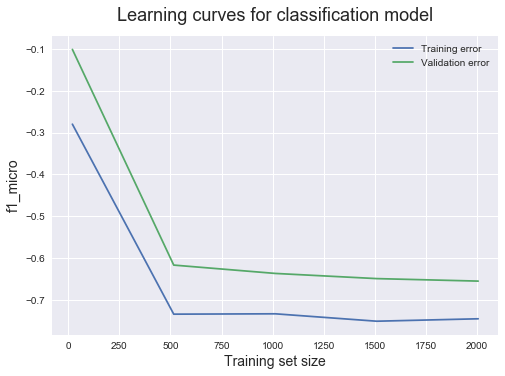

In [43]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('f1_micro', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for classification model', fontsize = 18, y = 1.03)
plt.legend()